# Productionized code

Run code with clean, feature-selected dataset

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

pd.set_option('display.max_columns', None)
plt.rcParams['figure.facecolor']='w'

import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

In [2]:
test = pd.read_csv('data/test.csv', index_col = 0)
train = pd.read_csv('data/train.csv', index_col = 0)

X_test = test.drop(columns = 'loan_status')
y_test = test.loan_status

X_train = train.drop(columns = 'loan_status')
y_train = train.loan_status



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test_scaled)

In [3]:
tree_model = DecisionTreeClassifier(criterion = 'entropy', 
                                        max_depth=6, max_features = 5, min_samples_split = 0.05, 
                                        splitter = 'best')

In [4]:
tree_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [5]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

Text(0.5, 1.0, 'Confusion Matrix for Decision Trees')

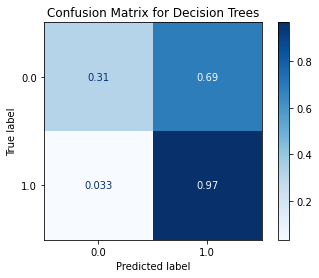

In [6]:
plot_confusion_matrix(tree_model, 
                      X_test_scaled,
                      y_test,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for Decision Trees')

Text(0.5, 1.0, 'Confusion Matrix for Decision Trees')

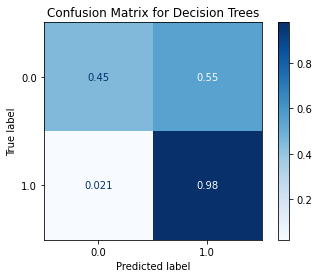

In [7]:
plot_confusion_matrix(tree_model, 
                      X_train_scaled,
                      y_train,
                      cmap= 'Blues', 
                      normalize = 'true')
plt.title('Confusion Matrix for Decision Trees')

In [8]:
feature_coef = pd.DataFrame(data=[X_train.columns, tree_model.feature_importances_]).transpose()

In [9]:
top_five_features = feature_coef.sort_values(by=[1], ascending=False)[:5]
top_five_features['Feature'] = ['Set Monthly Payment', '# Clients on Account', 'Credit Card Ownership', 'Latest Balance', '# Permanent Orders']

In [10]:
top_five_features

,0,1,Feature
0,latest_balance,0.346707,Set Monthly Payment
3,n_orders,0.233834,# Clients on Account
4,loan_amount,0.112455,Credit Card Ownership
10,loan_age,0.0983718,Latest Balance
2,card_age,0.0971822,# Permanent Orders


Text(0.5, 1.0, 'Most Important Features in Model')

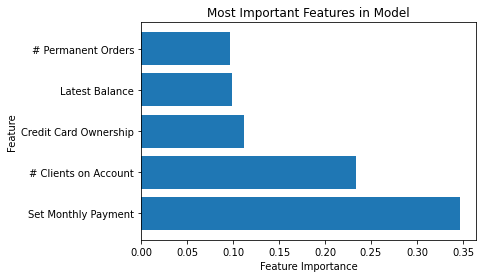

In [11]:



plt.barh(y=top_five_features['Feature'], width = top_five_features[1])

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Most Important Features in Model')

In [12]:
y_test_pred = tree_model.predict(X_test_scaled)

In [13]:
def getscores (true, pred):
    print(f'Recall: {recall_score(true,pred)} \n Precision: {precision_score(true,pred)} \n F1: {f1_score(true,pred)}')

In [14]:
getscores(y_test, y_test_pred)

Recall: 0.9669421487603306 
 Precision: 0.9140625 
 F1: 0.9397590361445782


In [15]:
tree_model.score(X_test_scaled, y_test)

0.8905109489051095